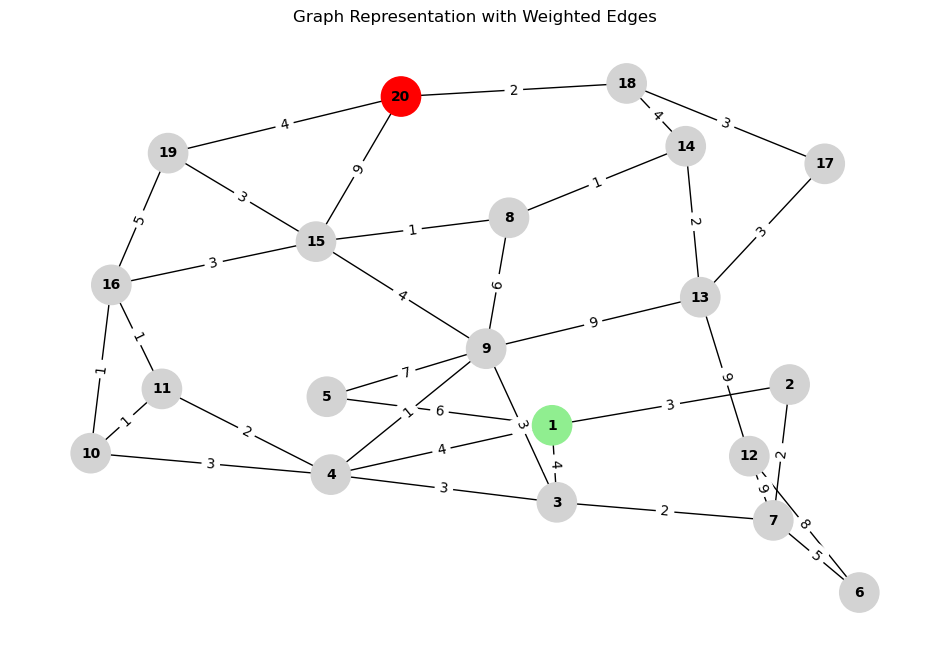

Topology matrix T: {1: {2: 3, 3: 4, 4: 4, 5: 6}, 2: {1: 3, 7: 2}, 3: {1: 4, 7: 2, 9: 3, 4: 3}, 4: {1: 4, 3: 3, 9: 1, 10: 3, 11: 2}, 5: {1: 6, 9: 7}, 7: {2: 2, 3: 2, 6: 5, 12: 9}, 9: {3: 3, 4: 1, 5: 7, 8: 6, 15: 4, 13: 9}, 10: {4: 3, 11: 1, 16: 1}, 11: {4: 2, 10: 1, 16: 1}, 6: {7: 5, 12: 8}, 12: {6: 8, 7: 9, 13: 9}, 8: {9: 6, 14: 1, 15: 1}, 14: {8: 1, 13: 2, 18: 4}, 15: {8: 1, 9: 4, 16: 3, 19: 3, 20: 9}, 13: {9: 9, 12: 9, 14: 2, 17: 3}, 16: {10: 1, 11: 1, 15: 3, 19: 5}, 17: {13: 3, 18: 3}, 18: {14: 4, 17: 3, 20: 2}, 19: {15: 3, 16: 5, 20: 4}, 20: {15: 9, 18: 2, 19: 4}}
Shortest path from 1 to 20: [1, 4, 9, 15, 19, 20]
Length of the shortest path: 16
Optimal path from 1 to 20 using Q-learning: [1, 4, 9, 15, 19, 20]
Length of the optimal path: 16


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

start = 1
end = 20
max_length = 20

# Initialize a graph
G = nx.Graph()

# Add nodes
nodes = range(1, 21)
G.add_nodes_from(nodes)

# Define edges with weights (based on the image)
edges = [
    (1, 2, 3), (1, 3, 4), (1, 4, 4), (1, 5, 6), 
    (2, 7, 2), (3, 7, 2), (3, 9, 3), (3, 4, 3),
    (4, 9, 1), (4, 10, 3), (4, 11, 2), (5, 1, 6),
    (5, 9, 7), (6, 7, 5), (7, 12, 9), (8, 9, 6),
    (8, 14, 1), (8, 15, 1), (9, 15, 4), (9, 13, 9),
    (10, 11, 1), (10, 16, 1), (11, 16, 1), (12, 6, 8),
    (12, 13, 9), (13, 14, 2), (14, 18, 4), (15, 16, 3),
    (15, 19, 3), (15, 20, 9), (16, 19, 5), (17, 13, 3),
    (17, 18, 3), (18, 20, 2), (19, 20, 4)
]

# Add edges with weights to the graph
G.add_weighted_edges_from(edges)

# Define node colors
node_colors = ['lightgreen' if node == start else 'red' if node == end else 'lightgray' for node in G.nodes()]

# Define position layout
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='fdp')

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw_networkx(G, pos, node_color=node_colors, with_labels=True, node_size=800, font_size=10, font_color='black', font_weight='bold', edge_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]}' for u, v, d in G.edges(data=True)}, font_color='black')

# Display the graph
plt.title("Graph Representation with Weighted Edges")
plt.axis('off')
plt.show()

# Create the topology matrix T from edges
T = {}
for u, v, d in G.edges(data=True):
    if u not in T:
        T[u] = {}
    if v not in T:
        T[v] = {}
    T[u][v] = d['weight']
    T[v][u] = d['weight']

print("Topology matrix T:", T)

# Shortest path using Dijkstra's algorithm
shortest_path = nx.shortest_path(G, source=start, target=end, weight='weight')
shortest_path_length = nx.shortest_path_length(G, source=start, target=end, weight='weight')

print(f"Shortest path from {start} to {end}:", shortest_path)
print("Length of the shortest path:", shortest_path_length)

def Q_routing(T, Q, alpha, epsilon, num_episodes, start, end):
    for e in range(num_episodes):
        state_cur = start
        visited = set()
        goal = False

        while not goal:
            mov_valid = list(Q[state_cur].keys())

            if not mov_valid:
                break

            if len(mov_valid) <= 1:
                state_nxt = mov_valid[0]
            else:
                act_best = min(Q[state_cur], key=Q[state_cur].get)
                if random.random() < epsilon:
                    mov_valid.remove(act_best)
                    if mov_valid:
                        state_nxt = random.choice(mov_valid)
                    else:
                        state_nxt = act_best
                else:
                    state_nxt = act_best

            Q = Q_update(T, Q, state_cur, state_nxt, alpha, visited)

            if state_nxt == end:
                goal = True
            state_cur = state_nxt
            if state_cur in visited or state_cur == end:
                break
            visited.add(state_cur)

    return Q

def Q_update(T, Q, state_cur, state_nxt, alpha, visited):
    t_cur = T[state_cur][state_nxt]
    q_cur = Q[state_cur][state_nxt]
    loop = 10 if state_nxt in visited else 0
    if state_nxt in Q:
        q_new = q_cur + alpha * (t_cur + min(Q[state_nxt].values()) + loop - q_cur)
        Q[state_cur][state_nxt] = q_new
    return Q

def get_key_of_min_value(d):
    min_value = min(d.values())
    return [k for k, v in d.items() if v == min_value]

def extract_best_path(Q, start, end):
    path = [start]
    current = start
    while current != end:
        next_state = min(Q[current], key=Q[current].get)
        path.append(next_state)
        current = next_state
    return path

# Example usage:
Q = {state: {next_state: 0 for next_state in T[state]} for state in T}

alpha = 0.1
epsilon = 0.1
num_episodes = 10000
end_state = end

Q = Q_routing(T, Q, alpha, epsilon, num_episodes, start, end_state)
optimal_path = extract_best_path(Q, start, end_state)
path_length = sum(T[optimal_path[i]][optimal_path[i + 1]] for i in range(len(optimal_path) - 1))

print(f"Optimal path from {start} to {end_state} using Q-learning:", optimal_path)
print("Length of the optimal path:", path_length)
